# Loan Grade, Sub-Grade and Interest Rate Prediction

## Setup

### Imports

In [1]:
%reload_ext autoreload
%autoreload 1
import joblib
from ray import tune
import copy
import shap
import matplotlib.pyplot as plt
import polars as pl
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import functions.transformers as tr
from functions.transformers import PolarsColumnTransformer as PCT
import functions.data_cleaning as dmf
import functions.plot_functions as pf
import functions.tuning as tunes
import functions.statistics as st
import functions.feature_engineering as feats
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,f1_score
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display,Markdown
import lightgbm as lgb
%aimport functions.tuning
%aimport functions.transformers
%aimport functions.data_cleaning
%aimport functions.plot_functions
%aimport functions.feature_engineering
%aimport functions.statistics

### Data Preparation

##### Loading the data:

In [2]:
data_train_single=pl.read_parquet('data/data_accepted_single_train.parquet')
data_val_single=pl.read_parquet('data/data_accepted_single_val.parquet')
data_test_single=pl.read_parquet('data/data_accepted_single_test.parquet')
data_train_joint=pl.read_parquet('data/data_accepted_joint_train.parquet')
data_val_joint=pl.read_parquet('data/data_accepted_joint_val.parquet')
data_test_joint=pl.read_parquet('data/data_accepted_joint_test.parquet')

#### Oversampling

##### Sub-grades with the lowest representation in single applications:

In [3]:
data_train_single['sub_grade'].value_counts().sort('counts')[:10]

sub_grade,counts
str,u32
"""G5""",873
"""G4""",1021
"""G3""",1447
"""G2""",2003
"""G1""",2637
"""F5""",3770
"""F4""",4773
"""F3""",6078
"""F2""",7532


##### Sub-grades with the lowest representation in joint applications:

In [4]:
data_train_joint['sub_grade'].value_counts().sort('counts')[:10]

sub_grade,counts
str,u32
"""G2""",78
"""G4""",79
"""G3""",79
"""G5""",90
"""F4""",154
"""G1""",171
"""F2""",185
"""F5""",187
"""F3""",253


In [5]:
data_train_single=data_train_single.vstack(st.oversample_polars(data_train_single,'sub_grade',10000))
data_train_joint=data_train_joint.vstack(st.oversample_polars(data_train_joint,'sub_grade',10000))

In [6]:
data_train_single=dmf.clean_accepted_single(data_train_single)
data_val_single=dmf.clean_accepted_single(data_val_single)
data_test_single=dmf.clean_accepted_single(data_test_single)
data_train_joint=dmf.clean_accepted_joint(data_train_joint)
data_val_joint=dmf.clean_accepted_joint(data_val_joint)
data_test_joint=dmf.clean_accepted_joint(data_test_joint)

##### Dropping Features:

In [7]:
data_train_single=dmf.remove_poor_features_single(data_train_single)
data_val_single=dmf.remove_poor_features_single(data_val_single)
data_test_single=dmf.remove_poor_features_single(data_test_single)
data_train_joint=dmf.remove_poor_features_joint(data_train_joint)
data_val_joint=dmf.remove_poor_features_joint(data_val_joint)
data_test_joint=dmf.remove_poor_features_joint(data_test_joint)

### Feature Engineering

In [8]:
data_train_single=feats.date_features(data_train_single,'issue_d')
data_val_single=feats.date_features(data_val_single,'issue_d')
data_test_single=feats.date_features(data_test_single,'issue_d')
data_train_joint=feats.date_features_joint(data_train_joint,'issue_d')
data_val_joint=feats.date_features_joint(data_val_joint,'issue_d')
data_test_joint=feats.date_features_joint(data_test_joint,'issue_d')

In [9]:
data_train_single=dmf.label_target_grades(data_train_single,)
data_val_single=dmf.label_target_grades(data_val_single,)
data_test_single=dmf.label_target_grades(data_test_single)
data_train_joint=dmf.label_target_grades(data_train_joint,)
data_val_joint=dmf.label_target_grades(data_val_joint,)
data_test_joint=dmf.label_target_grades(data_test_joint)

In [10]:
X_train_single=data_train_single.drop(columns=['grade','sub_grade','int_rate','issue_d'])
y_train_single=data_train_single['grade']

X_val_single=data_val_single.drop(columns=['grade','sub_grade','int_rate','issue_d'])
y_val_single=data_val_single['grade']

X_train_joint=data_train_joint.drop(columns=['grade','sub_grade','int_rate','issue_d'])
y_train_joint=data_train_joint['grade']

X_val_joint=data_val_joint.drop(columns=['grade','sub_grade','int_rate','issue_d'])
y_val_joint=data_val_joint['grade']

X_test_single=data_test_single.drop(columns=['grade','sub_grade','int_rate','issue_d'])
y_test_single=data_test_single['grade']

X_test_joint=data_test_joint.drop(columns=['grade','sub_grade','int_rate','issue_d'])
y_test_joint=data_test_joint['grade']

#### Imputers

In [11]:
preprocess_single=Pipeline([])

In [12]:
emp_title_imp = tr.NotInImputerPolars(cat_no=20, fill_value="other")
emp_length_imp = tr.NotInImputerPolars(cat_no=12, fill_value=None)
zip_imp = tr.NotInImputerPolars(cat_no=12, fill_value='other')
imputers = PCT(
    [
        PCT.Step("emp_title", emp_title_imp, "emp_title"),
        PCT.Step("emp_length", emp_length_imp, "emp_length"),
        PCT.Step("zip_code", zip_imp,'zip_code')
    ]
)
preprocess_single.steps.append(("imputers",imputers))

### Encoders

In [13]:
emp_t_enc = tr.TargetMeanOrderedLabeler(how="label")
emp_l_order = [
    None,
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years",
]
emp_l_enc = tr.PolarsOrdinalEncoder(order=emp_l_order)
home_enc = tr.TargetMeanOrderedLabeler(how="label")
verif_enc = tr.TargetMeanOrderedLabeler(how="label")
paymnt_enc = tr.PolarsOneHotEncoder(drop=True)
purpose_enc = tr.TargetMeanOrderedLabeler(how="label")
zip_enc = tr.TargetMeanOrderedLabeler(how="label")
state_enc = tr.TargetMeanOrderedLabeler(how="label")
init_stat_enc = tr.PolarsOneHotEncoder(drop=True)
disbursement_enc = tr.PolarsOneHotEncoder(drop=True)
year_enc = tr.TargetMeanOrderedLabeler(how="last_mean")

encoders = PCT(
    [
        PCT.Step("emp_t_enc", emp_t_enc, "emp_title"),
        PCT.Step("emp_l_enc", emp_l_enc, "emp_length"),
        PCT.Step("home_enc", home_enc, "home_ownership"),
        PCT.Step("verif_enc", verif_enc, "verification_status"),
        PCT.Step("paymnt_enc", paymnt_enc, "pymnt_plan"),
        PCT.Step("purpose_enc", purpose_enc, "purpose"),
        PCT.Step("zip_enc", zip_enc, "zip_code"),
        PCT.Step("state_enc", state_enc, "addr_state"),
        PCT.Step("init_stat_enc", init_stat_enc, "initial_list_status"),
        PCT.Step("disbursement_enc", disbursement_enc, "disbursement_method"),
        PCT.Step("year_enc", year_enc, "year")
    ]
)

preprocess_single.steps.append(("encoders",encoders))
null_imp = tr.PolarsNullImputer(fill_value=-9)
preprocess_single.steps.append(("null_imputer",null_imp))

In [14]:
model_single_lgbm = lgb.LGBMClassifier(
    objective="multiclass",
    class_weight="balanced",
    verbose=-1,
    force_col_wise=True,
    random_state=1,
    num_threads=6
)

##### Getting lists of selected features based on boruta algorithm with different strictness:

```python
original_columns = preprocess_single.fit_transform(
    X_train_single.sample(10000, seed=1), y_train_single.sample(10000, seed=1)
).columns

boruta_selected_cols = {}

transformed_sample_X = preprocess_single.fit_transform(
    X_train_single.sample(50000, seed=1), y_train_single.sample(50000, seed=1)
)
transformed_sample_y = y_train_single.sample(50000, seed=1)
for perc in np.arange(stop=101, start=10, step=10):
    boruta = tr.BorutaFeatureSelectorPolars(
        model_single_lgbm, random_state=1, perc=perc
    )

    boruta.fit(
        transformed_sample_X,
        transformed_sample_y,
    )
    boruta_selected_cols[perc] = boruta.transform(
        preprocess_single.fit_transform(
            X_train_single.sample(10000, seed=1), y_train_single.sample(10000, seed=1)
        )
    ).columns
    print(f"{perc} calculated")

# Setting the number of threads to 1 to avoid parallelization clash with ray tune.
model_single_lgbm = lgb.LGBMClassifier(
    objective="multiclass",
    class_weight="balanced",
    verbose=-1,
    force_col_wise=True,
    random_state=1,
    num_threads=1,
)

```python
cols_to_drop_space=[]
for key, columns in boruta_selected_cols.items():
    cols_to_drop_space.append([col for col in original_columns if col not in columns])
cols_to_drop_space.insert(0,[])
joblib.dump(cols_to_drop_space,'temp/cols_to_drop.joblib')


In [15]:
cols_to_drop_space=joblib.load('temp/cols_to_drop.joblib')

##### Dropper

In [16]:
feature_dropper = tr.FeatureRemover([])
preprocess_single.steps.append(('feature_dropper',feature_dropper))
full_pipeline_single = Pipeline(
    [("preprocess", preprocess_single), ("model", model_single_lgbm)]
)

##### Baseline for tuning:

In [17]:
full_pipeline_single.fit(X_train_single.sample(100000,seed=1),y_train_single.sample(100000,seed=1))
preds=full_pipeline_single.predict(X_val_single)
print(f1_score(y_val_single,preds,average='macro'))

0.3321204198360338


### Search space

In [18]:
models = tunes.Models()
search_space_lgbm = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space),
    "model__max_depth": tune.randint(5,50),
    "model__num_leaves": tune.randint(10, 3051),
    "model__n_estimators": tune.randint(10, 251),
    "model__learning_rate": tune.loguniform(0.001, 0.1),
    "model__bagging_freq": tune.randint(0, 11),
    "model__colsample_bytree": tune.uniform(0.2, 1.0),
    "model__subsample": tune.uniform(0.2, 1.0),
    "model__reg_alpha": tune.loguniform(0.001, 100),
    "model__reg_lambda": tune.loguniform(0.001, 100),
    "model__boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "model__class_weight": tune.choice(["balanced", None]),
    "model__max_bin": tune.randint(5, 201),
}

models.add_model("lgbm_grade_single", full_pipeline_single, search_space_lgbm, metric_threshold=0.35)

### Tree

In [19]:
preprocess_single_dtree = copy.deepcopy(preprocess_single)
model_single_dtree = DecisionTreeClassifier(random_state=1)
full_pipeline_single_dtree = Pipeline(
    [("preprocess", preprocess_single_dtree), ("model", model_single_dtree)]
)

search_space_tree = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space),
    "model__criterion": tune.choice(["gini", "entropy"]),
    "model__splitter": tune.choice(["best", "random"]),
    "model__max_depth": tune.randint(3, 50),
    "model__max_features": tune.choice(["sqrt", "log2", None]),
    "model__class_weight": tune.choice(["balanced", None]),
}

models.add_model(
    "tree_grade_single", full_pipeline_single_dtree, search_space_tree, metric_threshold=0.3,override_n=120
)

```python
models.tune_all(
    X_train_single,
    y_train_single,
    X_val_single,
    y_val_single,
    n=240,
    sample_size=15000,
    average="macro",
)
joblib.dump(models, "temp/tuned_grade_models.joblib")


In [20]:
models=joblib.load('temp/tuned_grade_models.joblib')

In [28]:
from pprint import pprint
for model in models.models.values():
    pprint (model.name)
    pprint(model.best_params)

'lgbm_grade_single'
{'model__bagging_freq': 9,
 'model__boosting_type': 'gbdt',
 'model__class_weight': 'balanced',
 'model__colsample_bytree': 0.6849549665551705,
 'model__learning_rate': 0.0558509334178991,
 'model__max_bin': 40,
 'model__max_depth': 33,
 'model__n_estimators': 204,
 'model__num_leaves': 2051,
 'model__reg_alpha': 0.0010009764783985519,
 'model__reg_lambda': 43.90677880592865,
 'model__subsample': 0.9796606370081837,
 'preprocess__feature_dropper__feats_to_drop': ['home_ownership',
                                                'delinq_2yrs',
                                                'fico_range_high',
                                                'mths_since_last_record',
                                                'pub_rec',
                                                'last_fico_range_low',
                                                'mths_since_last_major_derog',
                                                'acc_now_delinq',
               

In [29]:
for model in models.models.values():
    model.pipeline.fit(X_train_single,y_train_single)

preds_lgbm=models.models['lgbm_grade_single'].pipeline.predict(X_val_single)
preds_dtree=models.models['tree_grade_single'].pipeline.predict(X_val_single)
print(classification_report(y_val_single,preds_lgbm))
print(classification_report(y_val_single,preds_dtree))

              precision    recall  f1-score   support

           1       0.65      0.72      0.68     72529
           2       0.48      0.55      0.51    121365
           3       0.53      0.35      0.42    130148
           4       0.26      0.29      0.27     50567
           5       0.17      0.30      0.22     17982
           6       0.14      0.18      0.16      5509
           7       0.24      0.02      0.03      3054

    accuracy                           0.46    401154
   macro avg       0.35      0.34      0.33    401154
weighted avg       0.48      0.46      0.46    401154

              precision    recall  f1-score   support

           1       0.60      0.64      0.62     72529
           2       0.43      0.54      0.48    121365
           3       0.45      0.51      0.48    130148
           4       0.25      0.06      0.10     50567
           5       0.16      0.04      0.06     17982
           6       0.17      0.04      0.06      5509
           7       0.08 

In [30]:
best_pipeline_single=models.models['lgbm_grade_single'].pipeline

100%|===================| 3499/3500 [55:49<00:00]        

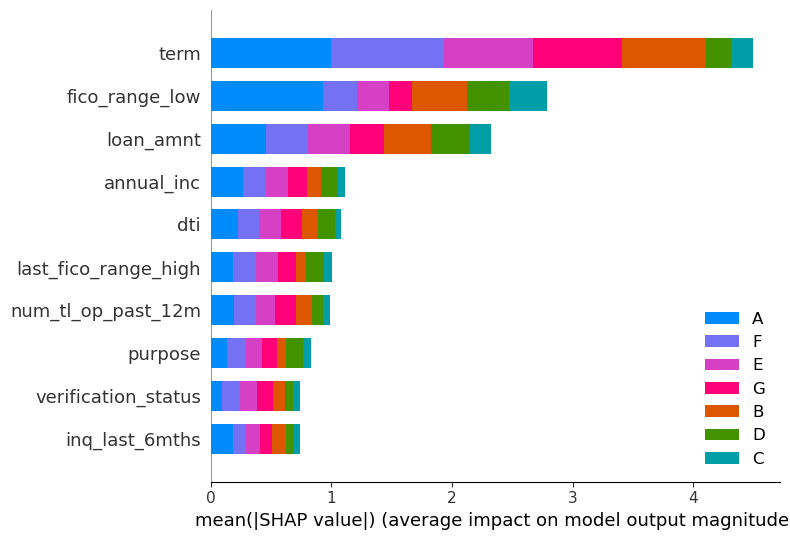

In [31]:
names = (
    models.models["lgbm_grade_single"]
    .pipeline["preprocess"]
    .transform(X_val_single.sample(500, seed=1))
    .columns
)
explainer_tree = shap.TreeExplainer(
    best_pipeline_single.pipeline["model"],
    data=best_pipeline_single
    .pipeline["preprocess"]
    .transform((X_val_single.sample(500, seed=1)))
    .to_numpy(),
    model_output="raw",
)

shap_values = explainer_tree.shap_values(
    best_pipeline_single
    .pipeline["preprocess"]
    .transform(X_val_single.sample(500, seed=1))
    .to_numpy()
)

shap.summary_plot(
    shap_values,
    best_pipeline_single
    .pipeline["preprocess"]
    .transform(X_val_single.sample(10000, seed=1))
    .to_numpy(),
    feature_names=names,
    class_names={0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G"},
    max_display=10,
)

### Final Testing

In [35]:
best_pipeline_single['model'].set_params(**{'num_threads':3})

LGBMClassifier(bagging_freq=9, class_weight='balanced',
               colsample_bytree=0.6849549665551705, force_col_wise=True,
               learning_rate=0.0558509334178991, max_bin=40, max_depth=33,
               n_estimators=204, num_leaves=2051, num_threads=3,
               objective='multiclass', random_state=1,
               reg_alpha=0.0010009764783985519, reg_lambda=43.90677880592865,
               subsample=0.9796606370081837, verbose=-1)

In [33]:
best_pipeline_single.fit(X_train_single.vstack(X_val_single),pl.concat([y_train_single,y_val_single]))

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputers',
                                  PolarsColumnTransformer(steps=OrderedDict([('emp_title',
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7f5e17ac79d0>),
                                                                             ('emp_length',
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7f5e17ac74f0>),
                                                                             ('zip_code',
                                                                              <functions.transformers.PolarsColumnTransformer.Step obje...
                 LGBMClassifier(bagging_freq=9, class_weight='balanced',
                                colsample_bytree=0.6849549665551705,
                                force_col_wise=True,
                                learning_rate=0.0558509334178991, max_bin=40,
                                max_depth=33, n_estimators=204, num_leaves=2051,
                                num_threads=2, objective='multiclass',
                                random_state=1, reg_alpha=0.0010009764783985519,
                                reg_lambda=43.90677880592865,
                                subsample=0.9796606370081837, verbose=-1))])

In [34]:
preds_single_final=best_pipeline_single.predict(X_test_single)
print(classification_report(y_test_single,preds_single_final))

              precision    recall  f1-score   support

           1       0.79      0.51      0.62    119923
           2       0.41      0.47      0.43    121995
           3       0.38      0.41      0.39    108373
           4       0.28      0.24      0.26     57923
           5       0.14      0.25      0.18     15356
           6       0.05      0.29      0.09      2266
           7       0.00      0.01      0.01       421

    accuracy                           0.42    426257
   macro avg       0.29      0.31      0.28    426257
weighted avg       0.48      0.42      0.44    426257



##### Exporting the final model:

In [36]:
best_pipeline_single.fit(
    X_train_single.vstack(X_val_single).vstack(X_test_single),
    pl.concat([y_train_single, y_val_single, y_test_single]),
)

joblib.dump(best_pipeline_single, "trained_models/model_single_grade.joblib")

['trained_models/model_single_grade.joblib']

### Joint Applications

##### Setting up joint application preprocessing:

In [20]:
imputers_joint = copy.deepcopy(imputers)
encoders_joint = copy.deepcopy(encoders)
encoders_to_delete = ["disbursement_enc", "paymnt_enc"]

for key in encoders_to_delete:
    del encoders_joint.steps[key]

verif_enc_joint = tr.TargetMeanOrderedLabeler(how="label")

encoders_joint.steps["verif_enc_joint"] = PCT.Step(
    "verif_enc_joint", verif_enc_joint, "verification_status_joint"
)

null_imp_joint = copy.deepcopy(null_imp)
feature_dropper_joint = tr.FeatureRemover([])

preprocess_joint = Pipeline(
    [
        ("imputers", imputers_joint),
        ("encoders", encoders_joint),
        ("null_imputer", null_imp_joint),
        ("feature_dropper", feature_dropper_joint),
    ]
)

model_joint = lgb.LGBMClassifier(
    objective="multiclass",
    class_weight="balanced",
    verbose=-1,
    force_col_wise=True,
    random_state=1,
    num_threads=12,
)

full_pipeline_joint = Pipeline(
    [("preprocess", preprocess_joint), ("model", model_joint)]
)

removal space:

```python
original_columns_joint = preprocess_joint.fit_transform(
    X_train_joint.sample(10000, seed=1), y_train_joint.sample(10000, seed=1)
).columns

boruta_selected_cols_joint = {}

transformed_sample_X = preprocess_joint.fit_transform(
    X_train_joint.sample(20000, seed=1), y_train_joint.sample(20000, seed=1)
)
transformed_sample_y = y_train_joint.sample(20000, seed=1)
for perc in np.arange(stop=101, start=10, step=10):
    boruta = tr.BorutaFeatureSelectorPolars(
        model_joint, random_state=1, perc=perc
    )

    boruta.fit(
        transformed_sample_X,
        transformed_sample_y,
    )
    boruta_selected_cols_joint[perc] = boruta.transform(
        preprocess_joint.fit_transform(
            X_train_joint.sample(10000, seed=1), y_train_joint.sample(10000, seed=1)
        )
    ).columns
    print(f"{perc} calculated")

# Setting the number of threads to 1 to avoid parallelization clash with ray tune.
model_joint = lgb.LGBMClassifier(
    objective="multiclass",
    class_weight="balanced",
    verbose=-1,
    force_col_wise=True,
    random_state=1,
    num_threads=1,
)


```python
cols_to_drop_space_joint=[]
for key, columns in boruta_selected_cols_joint.items():
    cols_to_drop_space_joint.append([col for col in original_columns_joint if col not in columns])
cols_to_drop_space_joint.insert(0,[])
joblib.dump(cols_to_drop_space_joint,'temp/cols_to_drop_joint.joblib')


In [29]:
cols_to_drop_space_joint=joblib.load('temp/cols_to_drop_joint.joblib')

In [24]:
search_space_lgbm_joint = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space_joint),
    "model__max_depth": tune.randint(5,40),
    "model__num_leaves": tune.randint(10, 2500),
    "model__n_estimators": tune.randint(10, 251),
    "model__learning_rate": tune.loguniform(0.001, 0.1),
    "model__bagging_freq": tune.randint(0, 11),
    "model__colsample_bytree": tune.uniform(0.2, 1.0),
    "model__subsample": tune.uniform(0.2, 1.0),
    "model__reg_alpha": tune.loguniform(0.001, 100),
    "model__reg_lambda": tune.loguniform(0.001, 100),
    "model__boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "model__class_weight": tune.choice(["balanced", None]),
    "model__max_bin": tune.randint(5, 201),
}

joint_grade_classifier = tunes.Models.Model(
    "joint_grade_lgbm",
    pipeline=full_pipeline_joint,
    param_grid=search_space_lgbm_joint,
    metric_threshold=0.3,
)

joint_grade_classifier.pipeline['model'].set_params(**{'num_threads':1})

LGBMClassifier(class_weight='balanced', force_col_wise=True, num_threads=1,
               objective='multiclass',
               random_state=RandomState(MT19937) at 0x7F1691AA8540, verbose=-1)

In [25]:
#```python
joint_grade_classifier.tune_model(
    X_train_joint,
    y_train_joint,
    X_val_joint,
    y_val_joint,
    n=240,
    sample_size=50000,
    n_training=1,
    average="macro",
)
joblib.dump(joint_grade_classifier, "temp/tuned_joint_grade.joblib")

(Trainable pid=52645) Step 0 F-1 Score: 0.185068337505191
(Trainable pid=52890) Step 0 F-1 Score: 0.33392284800940286
(Trainable pid=52756) Step 0 F-1 Score: 0.35195802413766447
(Trainable pid=52704) Step 0 F-1 Score: 0.3343281564022974 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(Trainable pid=52842) Step 0 F-1 Score: 0.3383380385633325 [repeated 4x across cluster]
(Trainable pid=53259) Step 0 F-1 Score: 0.2469360169263586 [repeated 3x across cluster]
(Trainable pid=53123) Step 0 F-1 Score: 0.37102361956968805
(Trainable pid=53344) Step 0 F-1 Score: 0.3380848926753154
(Trainable pid=53303) Step 0 F-1 Score: 0.3464068402896095
(Trainable pid=53437) Step 0 F-1 Score: 0.33921883890305715
(Trainable pid=54101) Step 0 F-1 Score: 0.3550187400775106 [repeated 2x across cluster]
(Trainable pid=54192) Step 0 F-1 Scor

2023-10-15 19:36:31,665	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.
2023-10-15 19:36:31,698	INFO tune.py:1143 -- Total run time: 1531.54 seconds (1531.19 seconds for the tuning loop).


['temp/tuned_joint_grade.joblib']

In [31]:
joint_grade_classifier=joblib.load("temp/tuned_joint_grade.joblib")

In [26]:
joint_grade_classifier.best_params

{'preprocess__feature_dropper__feats_to_drop': [],
 'model__max_depth': 23,
 'model__num_leaves': 1914,
 'model__n_estimators': 188,
 'model__learning_rate': 0.07073565588841094,
 'model__bagging_freq': 6,
 'model__colsample_bytree': 0.5167584359479642,
 'model__subsample': 0.8708296688477901,
 'model__reg_alpha': 12.533291967833335,
 'model__reg_lambda': 0.00745184747969614,
 'model__boosting_type': 'gbdt',
 'model__class_weight': None,
 'model__max_bin': 48}

In [27]:
joint_grade_classifier.pipeline['model'].set_params(**{'num_threads':12})
joint_grade_classifier.pipeline.fit(X_train_joint,y_train_joint)
preds_joint_grade=joint_grade_classifier.pipeline.predict(X_val_joint)
print(classification_report(y_val_joint,preds_joint_grade))


              precision    recall  f1-score   support

           1       0.77      0.73      0.75      6153
           2       0.53      0.54      0.53      8269
           3       0.44      0.63      0.52      8318
           4       0.39      0.21      0.28      4926
           5       0.38      0.18      0.25      1511
           6       0.27      0.10      0.15       488
           7       0.00      0.00      0.00       137

    accuracy                           0.52     29802
   macro avg       0.40      0.34      0.35     29802
weighted avg       0.52      0.52      0.51     29802



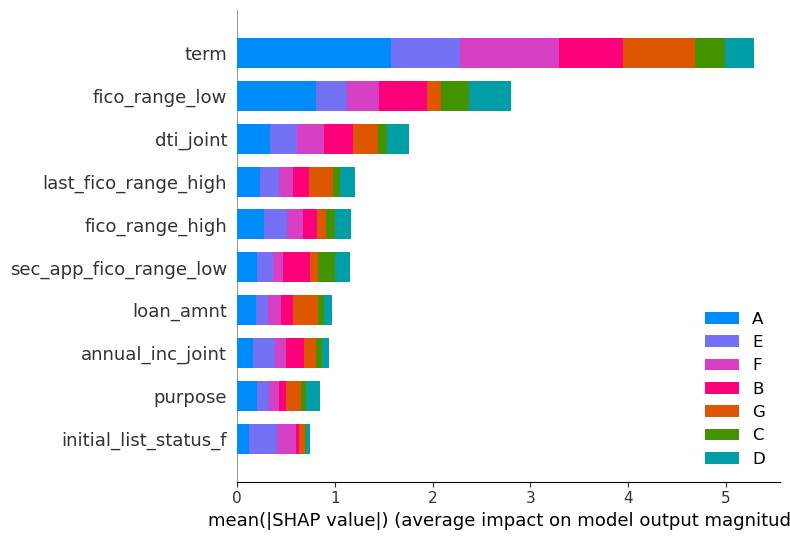

In [29]:
names_joint_grade = (
    joint_grade_classifier.pipeline["preprocess"]
    .transform(X_val_joint.sample(500, seed=1))
    .columns
)
explainer_joint_grade = shap.TreeExplainer(
    joint_grade_classifier.pipeline["model"],
    data=joint_grade_classifier.pipeline["preprocess"]
    .transform((X_val_joint.sample(500, seed=1)))
    .to_numpy(),
    model_output="raw",
)

shap_values_joint_grade = explainer_joint_grade.shap_values(
    joint_grade_classifier.pipeline["preprocess"]
    .transform(X_val_joint.sample(500, seed=1))
    .to_numpy(),
    approximate=True
)

shap.summary_plot(
    shap_values_joint_grade,
    joint_grade_classifier.pipeline["preprocess"]
    .transform(X_val_joint.sample(10000, seed=1))
    .to_numpy(),
    feature_names=names_joint_grade,
    class_names={0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G"},
    max_display=10,
)

#### Final Testing

In [30]:
joint_grade_classifier.pipeline.fit(X_train_joint.vstack(X_val_joint),pl.concat([y_train_joint,y_val_joint]))

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputers',
                                  PolarsColumnTransformer(steps=OrderedDict([('emp_title',
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7f168fe8ee80>),
                                                                             ('emp_length',
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7f168fe8ef70>),
                                                                             ('zip_code',
                                                                              <functions.transformers.PolarsColumnTransformer.Step obje...
                 LGBMClassifier(bagging_freq=6,
                                colsample_bytree=0.5167584359479642,
                                force_col_wise=True,
                                learning_rate=0.07073565588841094, max_bin=48,
                                max_depth=23, n_estimators=188, num_leaves=1914,
                                num_threads=12, objective='multiclass',
                                random_state=RandomState(MT19937) at 0x7F1691AA8540,
                                reg_alpha=12.533291967833335,
                                reg_lambda=0.00745184747969614,
                                subsample=0.8708296688477901, verbose=-1))])

In [36]:
preds_joint_grade_final=joint_grade_classifier.pipeline.predict(X_test_joint)
print(classification_report(y_test_joint,preds_joint_grade_final))

              precision    recall  f1-score   support

           1       0.76      0.76      0.76      6921
           2       0.50      0.60      0.55      8069
           3       0.47      0.38      0.42      7397
           4       0.39      0.50      0.44      4496
           5       0.30      0.11      0.16      1521
           6       0.16      0.03      0.04       275
           7       0.00      0.00      0.00        78

    accuracy                           0.53     28757
   macro avg       0.37      0.34      0.34     28757
weighted avg       0.52      0.53      0.52     28757



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


##### Exporting the final model:

In [31]:
joint_grade_classifier.pipeline.fit(
    X_train_joint.vstack(X_val_joint).vstack(X_test_joint),
    pl.concat([y_train_joint, y_val_joint, y_test_joint]),
)

joblib.dump(joint_grade_classifier.pipeline, "trained_models/model_joint_grade.joblib")

['trained_models/model_joint_grade.joblib']

## Sub-grade Prediction

##### Setting up the target variables:

In [38]:
data_train_single=dmf.label_target_sub_grades(data_train_single,)
data_val_single=dmf.label_target_sub_grades(data_val_single,)
data_test_single=dmf.label_target_sub_grades(data_test_single)
data_train_joint=dmf.label_target_sub_grades(data_train_joint,)
data_val_joint=dmf.label_target_sub_grades(data_val_joint,)
data_test_joint=dmf.label_target_sub_grades(data_test_joint)

In [39]:
y_train_single_subgrade=data_train_single['sub_grade']
y_val_single_subgrade=data_val_single['sub_grade']
y_test_single_subgrade=data_test_single['sub_grade']
y_train_joint_subgrade=data_train_joint['sub_grade']
y_val_joint_subgrade=data_val_joint['sub_grade']
y_test_joint_subgrade=data_test_joint['sub_grade']

### Single Application Sub-Grade Model

#### Setting up the pipeline:

In [52]:
preprocess_single_subgrade_cl = copy.deepcopy(preprocess_single)
preprocess_single_subgrade_rg = copy.deepcopy(preprocess_single)

model_single_sg_cl = lgb.LGBMClassifier(
    objective="multiclass",
    verbose=-1,
    force_col_wise=True,
    random_state=1,
    num_threads=1,
)

model_single_sg_rg = lgb.LGBMRegressor(
    verbose=-1, force_col_wise=True, random_state=1, num_threads=1
)
regressor_wraper_single=tr.ModelWrapper(model_single_sg_rg)

sub_grade_rounder = tr.RoundToRangeTransformer(1, 35)
pipeline_single_sg_cl = Pipeline(
    [("preprocess", preprocess_single_subgrade_cl), ("model", model_single_sg_cl)]
)
pipeline_single_sg_rg = Pipeline(
    [
        ("preprocess", preprocess_single_subgrade_rg),
        ("model", regressor_wraper_single),
        ("rounding", sub_grade_rounder),
    ]
)

In [51]:
pipeline_single_sg_cl.fit(
    X_train_single.sample(50000, seed=1), y_train_single_subgrade.sample(50000, seed=1)
)
pipeline_single_sg_rg.fit(
    X_train_single.sample(50000, seed=1), y_train_single_subgrade.sample(50000, seed=1)
)

initial_preds_sg_cl = pipeline_single_sg_cl.predict(X_val_single.sample(10000, seed=1))
initial_preds_sg_rg = pipeline_single_sg_rg.predict(X_val_single.sample(10000, seed=1))

print(
    f1_score(
        y_val_single_subgrade.sample(10000, seed=1),
        initial_preds_sg_cl,
        average="macro",
    )
)
print(
    f1_score(
        y_val_single_subgrade.sample(10000, seed=1),
        initial_preds_sg_rg,
        average="macro",
    )
)

KeyboardInterrupt: 

In [54]:
pipeline_single_sg_rg.steps

[('preprocess',
  Pipeline(steps=[('imputers',
                   PolarsColumnTransformer(steps=OrderedDict([('emp_title',
                                                               <functions.transformers.PolarsColumnTransformer.Step object at 0x7f9899d2d580>),
                                                              ('emp_length',
                                                               <functions.transformers.PolarsColumnTransformer.Step object at 0x7f9899d2c430>),
                                                              ('zip_code',
                                                               <functions.transformers.PolarsColumnTransformer.Step object at 0x7f9899d2c520>)]))),
                  ('enc...
                                                               <functions.transformers.PolarsColumnTransformer.Step object at 0x7f9899d2f4f0>),
                                                              ('disbursement_enc',
                                   

#### Tuning

In [59]:
models_sub_single = tunes.Models()
search_space_sg_cl = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space),
    "model__num_leaves": tune.randint(10, 1025),
    "model__n_estimators": tune.randint(10, 251),
    "model__learning_rate": tune.loguniform(0.001, 0.1),
    "model__bagging_freq": tune.randint(0, 11),
    "model__colsample_bytree": tune.uniform(0.2, 1.0),
    "model__subsample": tune.uniform(0.2, 1.0),
    "model__reg_alpha": tune.loguniform(0.001, 100),
    "model__reg_lambda": tune.loguniform(0.001, 100),
    "model__boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "model__class_weight": tune.choice(["balanced", None]),
    "model__max_bin": tune.randint(5, 201),
}

models_sub_single.add_model("cl_subgrade_single", pipeline_single_sg_cl, search_space_sg_cl, metric_threshold=0.1)

In [60]:
search_space_sg_rg = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space),
    'model__param_grid': {
    "num_leaves": tune.randint(10, 1025),
    "n_estimators": tune.randint(10, 251),
    "learning_rate": tune.loguniform(0.001, 0.1),
    "bagging_freq": tune.randint(0, 11),
    "colsample_bytree": tune.uniform(0.2, 1.0),
    "subsample": tune.uniform(0.2, 1.0),
    "reg_alpha": tune.loguniform(0.001, 100),
    "reg_lambda": tune.loguniform(0.001, 100),
    "boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "class_weight": tune.choice(["balanced", None]),
    "max_bin": tune.randint(5, 256)}
}

models_sub_single.add_model("rg_subgrade_single", pipeline_single_sg_rg, search_space_sg_rg, metric_threshold=0.1)

In [63]:
models_sub_single.tune_all(X_train_single,
    y_train_single_subgrade,
    X_val_single,
    y_val_single_subgrade,
    n=360,
    n_training = 3,
    sample_size=20000,
    average="macro",)

joblib.dump(models_sub_single,'temp/models_sub_single.joblib')

2023-10-15 13:16:30,343	WARNING tune.py:194 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2023-10-15 13:16:30,353	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.
2023-10-15 13:16:38,277	INFO tune.py:1143 -- Total run time: 11.36 seconds (3.42 seconds for the tuning loop).
2023-10-15 13:16:38,278	WARNING tune.py:1158 -- Experiment has been interrupted, but the most

TypeError: sklearn.pipeline.Pipeline.set_params() argument after ** must be a mapping, not NoneType

(Trainable pid=10162) Trainable.setup took 10.024 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
